In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import torch.utils.data as utils
import time
import os
import torch.nn as nn
from torch.autograd import Function
import torchvision
import torch.utils.data as data
from PIL import Image
import os
import math
import matplotlib.pyplot as plt
pi=3.14

In [2]:
class GRL(Function):
    @staticmethod
    def forward(ctx, tensor, constant):
        ctx.constant = constant
        return tensor * constant
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.constant, None

In [3]:
class Dann(nn.Module):
    def __init__(self):
        super(Dann, self).__init__()
        hidden=100
        self.f = nn.Sequential(
                nn.Linear(2,hidden),
                #nn.BatchNorm1d(100),
                nn.ReLU(),
            )
        self.lc = nn.Sequential(   
            nn.Linear(hidden,2),
        )
        self.dc = nn.Sequential(
            nn.Linear(hidden,2),
        )
    def forward(self, x,alpha=0.5):
        x = self.f(x)
        y = GRL.apply(x, alpha)
        x = self.lc(x)
        y = self.dc(y)
        return x,y

In [4]:
def PointsInCircum(r,n=100):
    return [(math.cos(2*pi/n*x)*r,math.sin(2*pi/n*x)*r) for x in range(0,n)]

In [5]:
a = PointsInCircum(1)
b = PointsInCircum(0.9)

In [6]:
x0 = np.concatenate(a).reshape(100,2)
x1 = np.concatenate(b).reshape(100,2)
ones=np.ones(50)
label = np.concatenate((ones*0,ones*1,ones*2,ones*3))

In [7]:
c, s = np.cos(np.radians(30)), np.sin(np.radians(30))
R = np.array(((c,-s), (s, c)))
x1 = x1.dot(R)

In [8]:
for i in range(100):
    if(i < 50):
        x0[i,0] += 0.4
        x1[i,0] += 0.4
        x0[i,1] -= 0.2
        x1[i,1] -= 0.2
    else:
        x0[i,0] -= 0.4
        x1[i,0] -= 0.4
        x0[i,1] += 0.2
        x1[i,1] += 0.2
x = np.concatenate((x0,x1),axis=0)

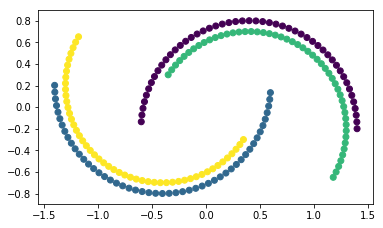

In [9]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(x[:,0],x[:,1],c=label)
plt.show()

In [10]:
source_train = torch.utils.data.DataLoader(np.arange(0,100),batch_size=10, shuffle=True)
target_train = torch.utils.data.DataLoader(np.arange(0,100),batch_size=10, shuffle=True)

In [11]:
x0 = torch.from_numpy(x0).type(torch.float32)
x1 = torch.from_numpy(x1).type(torch.float32)

In [12]:
device='cuda'
model = Dann().to(device)
optimizer = optim.Adam(model.parameters(),weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

In [13]:
label0 = torch.from_numpy(np.concatenate((np.ones(50)*0,np.ones(50)*1))).type(torch.LongTensor)
#label1 = torch.from_numpy(np.concatenate((np.ones(50)*2,np.ones(50)*3))).type(torch.LongTensor)

In [14]:
allepoch=600

In [15]:
for epoch in range(allepoch):
    len_dataloader = min(len(source_train), len(target_train))
    total_steps = allepoch * len(source_train)
    i = 0
    model.train()
    for batch_idx, (source_ind, target_ind) in enumerate(zip(source_train, target_train)):
        start_time = time.time()
        start_steps = epoch * len(source_train)
        p = float(i + start_steps) / total_steps
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        _, c = model(x1[target_ind].to(device),alpha)
        err_t_domain = criterion(c, torch.ones(len(target_ind)).type(torch.LongTensor).to(device))

        a, b = model(x0[source_ind].to(device),alpha)
        err_s_label = criterion(a, label0[source_ind].to(device))
        err_s_domain = criterion(b, torch.zeros(len(target_ind)).type(torch.LongTensor).to(device))

        err = err_s_label# + err_s_domain + err_t_domain
        optimizer.zero_grad()
        err.backward()
        optimizer.step()

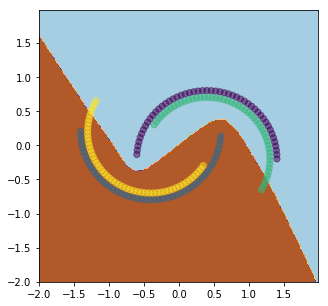

In [16]:
x_min, x_max = -2,2#x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = -2,2#x[:, 1].min() - 1, x[:, 1].max() + 1
h = .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    output,_ = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float32).to(device))
    Z = output.max(1, keepdim=True)[1].cpu().numpy()
Z = Z.reshape(xx.shape)
plt.figure(figsize=(5, 5))
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(x[:,0], x[:,1],c=label,s=40,alpha=0.5)
plt.show()

In [17]:
model = Dann().to(device)
optimizer = optim.Adam(model.parameters(),weight_decay=1e-5)

In [18]:
for epoch in range(allepoch):
    len_dataloader = min(len(source_train), len(target_train))
    total_steps = allepoch * len(source_train)
    i = 0
    model.train()
    for batch_idx, (source_ind, target_ind) in enumerate(zip(source_train, target_train)):
        start_time = time.time()
        start_steps = epoch * len(source_train)
        p = float(i + start_steps) / total_steps
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        _, c = model(x1[target_ind].to(device),alpha)
        err_t_domain = criterion(c, torch.ones(len(target_ind)).type(torch.LongTensor).to(device))

        a, b = model(x0[source_ind].to(device),alpha)
        err_s_label = criterion(a, label0[source_ind].to(device))
        err_s_domain = criterion(b, torch.zeros(len(target_ind)).type(torch.LongTensor).to(device))

        err = err_s_label + err_s_domain + err_t_domain
        optimizer.zero_grad()
        err.backward()
        optimizer.step()


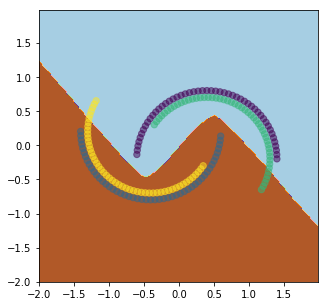

In [19]:
x_min, x_max = -2,2#x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = -2,2#x[:, 1].min() - 1, x[:, 1].max() + 1
h = .02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    output,_ = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).type(torch.float32).to(device))
    Z = output.max(1, keepdim=True)[1].cpu().numpy()
Z = Z.reshape(xx.shape)
plt.figure(figsize=(5, 5))
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(x[:,0], x[:,1],c=label,s=40,alpha=0.5)
plt.show()